In [13]:
!pip install transformers datasets scikit-learn pandas --quiet

# 📥 Импорты
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [14]:
df = pd.read_csv('/content/multilang_dataset_40000_utf8sig.csv')


            text    label
0     Я не понял  Russian
1  I'll be there  English
2      Я голоден  Russian
3     Ты молодец  Russian
4     No problem  English


<ipython-input-15-86e3939effba>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


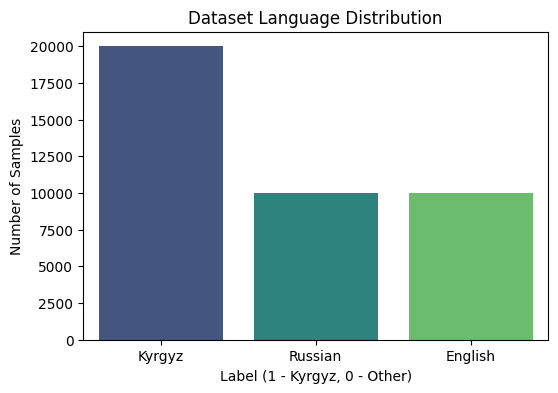

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
print(df.head())

# Посмотрим распределение по лейблам
label_counts = df['label'].value_counts()

# Построим график
plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Dataset Language Distribution")
plt.xlabel("Label (1 - Kyrgyz, 0 - Other)")
plt.ylabel("Number of Samples")
plt.show()

In [16]:
df['label'] = df['label'].apply(lambda x: 1 if x == 'Kyrgyz' else 0)


In [17]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, stratify=df['label'], random_state=42
)

In [18]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")


In [19]:
import numpy as np
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

# 📄 Создание Dataset
train_texts_array = np.asarray(train_texts)
train_labels_array = np.asarray(train_labels)
val_texts_array = np.asarray(val_texts)
val_labels_array = np.asarray(val_labels)

# Создание датасетов
train_dataset = Dataset.from_dict({"text": train_texts_array, "label": train_labels_array})
val_dataset = Dataset.from_dict({"text": val_texts_array, "label": val_labels_array})

# Применение токенизации
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Удаление колонки "text"
train_dataset = train_dataset.remove_columns(["text"])
val_dataset = val_dataset.remove_columns(["text"])

Map:   0%|          | 0/32000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

In [20]:
model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=2)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [22]:
training_args = TrainingArguments(
    output_dir="/content/results",
    eval_strategy="epoch",  # заменили evaluation_strategy на eval_strategy
    save_strategy="epoch",
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="/content/logs",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [23]:
!pip install wandb

In [24]:
import os
os.environ["WANDB_DISABLED"] = "true"
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.002300,0.000006,1.000000,1.000000


TrainOutput(global_step=2000, training_loss=0.01673291004623752, metrics={'train_runtime': 1001.0907, 'train_samples_per_second': 31.965, 'train_steps_per_second': 1.998, 'total_flos': 2104888442880000.0, 'train_loss': 0.01673291004623752, 'epoch': 1.0})

In [25]:
print(df['label'].value_counts())


label
0    20000
1    20000
Name: count, dtype: int64


In [26]:
predictions = trainer.predict(val_dataset)
preds = predictions.predictions.argmax(axis=-1)
print(classification_report(val_labels, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4000
           1       1.00      1.00      1.00      4000

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



100%|██████████| 1000/1000 [00:13<00:00, 73.59it/s]


<Figure size 600x500 with 0 Axes>

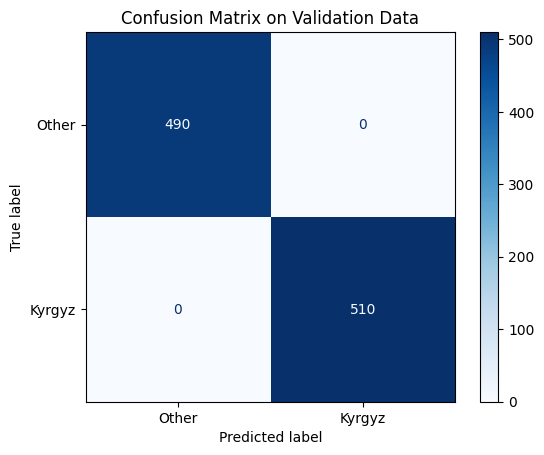

In [27]:
from tqdm import tqdm
import torch # Ensure torch is imported
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Ensure these are imported
import matplotlib.pyplot as plt # Ensure plt is imported

val_df = df.sample(1000)

# Предсказания
true_labels = val_df['label'].tolist()
pred_labels = []

# Determine the device of the model
device = model.device # Add this line to get the model's device

for text in tqdm(val_df['text']):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

    inputs = {key: val.to(device) for key, val in inputs.items()} # Add this line

    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    pred = torch.argmax(probs, dim=-1).item()
    pred_labels.append(pred)

# Построение confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Other", "Kyrgyz"])

# Визуализация
plt.figure(figsize=(6, 5))
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix on Validation Data")
plt.show()

In [28]:
model.save_pretrained("./my_kyrgyz_classifier")
tokenizer.save_pretrained("./my_kyrgyz_classifier")

('./my_kyrgyz_classifier/tokenizer_config.json',
 './my_kyrgyz_classifier/special_tokens_map.json',
 './my_kyrgyz_classifier/sentencepiece.bpe.model',
 './my_kyrgyz_classifier/added_tokens.json',
 './my_kyrgyz_classifier/tokenizer.json')

In [32]:
import torch

def predict_language(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

    # Определяем устройство модели
    device = model.device

    # Перемещаем входные тензоры на то же устройство, что и модель
    inputs = {k: v.to(device) for k, v in inputs.items()}

    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    pred = torch.argmax(probs, dim=-1).item()

    if pred == 1:
        return "Кыргызское"
    else:
        return "Другое"

# Пример
result = predict_language("Жакшы")
print(result)

Кыргызское


In [33]:
!zip -r my_kyrgyz_classifier.zip my_kyrgyz_classifier


  adding: my_kyrgyz_classifier/ (stored 0%)
  adding: my_kyrgyz_classifier/sentencepiece.bpe.model (deflated 49%)
  adding: my_kyrgyz_classifier/tokenizer.json (deflated 76%)
  adding: my_kyrgyz_classifier/model.safetensors (deflated 29%)
  adding: my_kyrgyz_classifier/tokenizer_config.json (deflated 76%)
  adding: my_kyrgyz_classifier/config.json (deflated 50%)
  adding: my_kyrgyz_classifier/special_tokens_map.json (deflated 52%)


In [34]:
from google.colab import files
files.download("my_kyrgyz_classifier.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>